In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error

In [ ]:
train_for = 600
predict_for = 14

In [ ]:
def smoothen_freq(df):
  x = df
  nan_indices = np.isnan(x)

  # # Remove the NaN values from the array
  x = x[np.logical_not(nan_indices)]

  # Generate a noisy signal
  signal = x

  # Apply Fourier transform to the signal
  f_signal = np.fft.fft(signal)

  # Calculate the power spectrum
  power = np.abs(f_signal)**2

  # Set a threshold to remove the noise
  threshold = 0.005 * max(power)
  f_signal[power < threshold] = 0

  # Apply inverse Fourier transform to the filtered signal
  filtered_signal = np.fft.ifft(f_signal)

  return filtered_signal


In [ ]:
look_back = 50

def prepare_data(df):
    X = []
    y = []
    for i in range(look_back, len(df)):
        y.append(df[i])
        X.append(df[i - look_back:i])
    return np.array(X), np.array(y)

In [ ]:
def scale(df, scaler):
  simple_array = np.array(df).reshape(-1, 1)
  ssimple_array = scaler.fit_transform(simple_array)
  return np.array(ssimple_array).reshape((-1, ))

def descaled(df, scaler):
  simple_array = np.array(df).reshape(-1, 1)
  ssimple_array = scaler.inverse_transform(simple_array)
  return np.array(ssimple_array).reshape((-1, ))

In [ ]:
class Model:
  def __init__(self, df):
    self.model=None
    self.scaler = MinMaxScaler()
    # self.df = smoothen_freq(df)
    self.df = scale(df, self.scaler)
    self.dfw, self.dfy = prepare_data(self.df)

    model_strong = tf.keras.Sequential([
        LSTM(units = 32, return_sequences=True, input_shape = (self.dfw.shape[1], 1)),
        LSTM(units = 32, return_sequences=True),
        LSTM(units = 32),
        Dense(units = 32)
    ])
    
    model_weak=tf.keras.Sequential([
        LSTM(units = 32, return_sequences=True, input_shape = (self.dfw.shape[1], 1)),
        Dropout(0.5),
        LSTM(units = 32, return_sequences=True),
        Dropout(0.5),
        LSTM(units = 32),
        Dropout(0.5),
        Dense(units = 32)
    ])

    concatenated=tf.keras.layers.Concatenate()([model_strong.output, model_weak.output])
    l1=tf.keras.layers.Dense(64)(concatenated)
    l2=tf.keras.layers.Dense(32)(l1)
    l3=tf.keras.layers.Dense(16)(l2)
    l4=tf.keras.layers.Dense(8)(l3)
    l5=tf.keras.layers.Dense(4)(l4)
    l6=tf.keras.layers.Dense(2)(l5)
    l7=tf.keras.layers.Dense(1)(l6)


    

    self.model=tf.keras.Model(inputs=[model_strong.input, model_weak.input], outputs=l7)
    self.model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    

  def fit(self):
    y_train = self.dfy 
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    self.model.fit([self.dfw, self.dfw], y_train, epochs = 100, callbacks=[callback])
  
  def predict(self, predict_for):
    df_full = self.dfw[-1]

    X_p = [df_full]
    y_p = []

    for i in range(predict_for):
        yi = self.model.predict([np.array(X_p), np.array(X_p)])
        y_p.append(yi[0][0])
        
        X_p = [np.append(X_p[0][1:], yi)]

    return descaled(y_p, self.scaler)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def smoothen(df, period):
    df_ma = df.copy()
    for i in range(period, len(df)):
        ma = 0
        for j in range(i - period + 1, i + 1):
            ma += df[j]
        df_ma[i] = ma / period
    return df_ma

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/covid-final-all.csv')
df['state_residence'] = df.apply(lambda row: row['state_residence'].lower(), axis=1)
df=df.groupby(['Date']).agg({'F_pos': 'sum', 'M_pos': 'sum', 'T_pos':'sum', 'NIA_pos':'sum', 'new_case': 'sum'}).reset_index()

date = df.iloc[train_for + 1]['Date']

df_f = df['F_pos'].values
df_m = df['M_pos'].values
df_t = df['T_pos'].values
df_nia = df['NIA_pos'].values

df = df_f + df_m + df_t + df_nia
df = smoothen(df, 3)

In [ ]:

df_train = df[:train_for]
df_test = df[train_for:train_for+predict_for]

In [ ]:
model = Model(df_train)

In [ ]:
model.fit()

Epoch 1/100
18/18 [==============================] - 15s 95ms/step - loss: 0.0210
Epoch 2/100
18/18 [==============================] - 2s 97ms/step - loss: 0.0072
Epoch 3/100
18/18 [==============================] - 2s 97ms/step - loss: 0.0036
Epoch 4/100
18/18 [==============================] - 2s 134ms/step - loss: 0.0033
Epoch 5/100
18/18 [==============================] - 3s 175ms/step - loss: 0.0024
Epoch 6/100
18/18 [==============================] - 2s 103ms/step - loss: 0.0020
Epoch 7/100
18/18 [==============================] - 2s 97ms/step - loss: 0.0023
Epoch 8/100
18/18 [==============================] - 2s 104ms/step - loss: 0.0022
Epoch 9/100
18/18 [==============================] - 2s 96ms/step - loss: 0.0017
Epoch 10/100
18/18 [==============================] - 2s 97ms/step - loss: 0.0019
Epoch 11/100
18/18 [==============================] - 2s 141ms/step - loss: 0.0017
Epoch 12/100
18/18 [==============================] - 3s 169ms/step - loss: 0.0017
Epoch 13/100
18/18

In [ ]:
y_pred = model.predict(predict_for)

1/1 [==============================] - 0s 31ms/step


In [ ]:
y_test = df_test


def mape_(p, a):
  print(len(p))
  print(len(a))
  # assert(len(p) == len(a))
  m = 0.0
  for i in range(len(p)):
    m += abs(p[i] - a[i]) / a[i]
  return( m / len(p)) * 100




print(mape_(y_pred, y_test))

14
14
15.065983759806766


In [ ]:
print(mape_(y_pred, y_test))

14
14
15.065983759806766


In [ ]:
print(y_pred)

[36082.94  35789.008 35879.043 36275.83  36900.13  37687.848 38594.145
 39591.3   40664.445 41807.055 43017.44  44296.152 45644.688 47064.582]


In [ ]:
print(y_test)

[47562.33333333 47157.         46558.33333333 38129.
 40181.33333333 41856.33333333 49650.66666667 46641.
 45121.66666667 43952.33333333 35452.33333333 37773.
 37974.         44481.        ]


In [ ]:
import matplotlib.pyplot as plt
def append(a, b):
  c = []
  for ai in a:
    c.append(ai)
  for bi in b:
    c.append(bi)
  return c

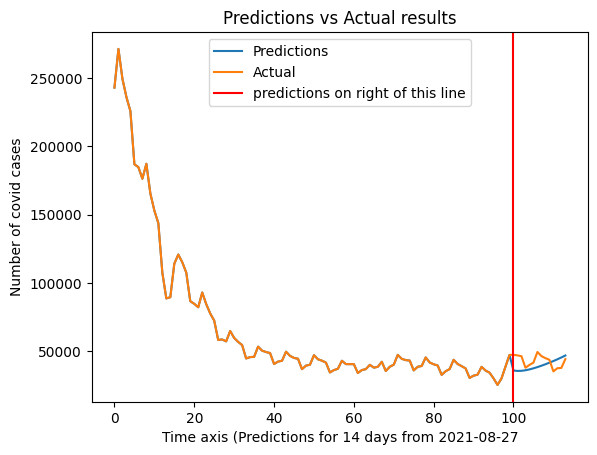

In [ ]:
window = 100
plt.figure()
plt.title("Predictions vs Actual results")
plt.plot(append(df[train_for - window:train_for], y_pred), label="Predictions")
plt.plot(append(df[train_for - window:train_for], y_test), label="Actual")
plt.xlabel("Time axis (Predictions for 14 days from " + date)
plt.ylabel("Number of covid cases")
plt.axvline(window, color = 'red', label = "predictions on right of this line")
plt.legend()
plt.show()

In [ ]:
print(y_pred)

[36082.94  35789.008 35879.043 36275.83  36900.13  37687.848 38594.145
 39591.3   40664.445 41807.055 43017.44  44296.152 45644.688 47064.582]


In [ ]:
print(y_test)

[47562.33333333 47157.         46558.33333333 38129.
 40181.33333333 41856.33333333 49650.66666667 46641.
 45121.66666667 43952.33333333 35452.33333333 37773.
 37974.         44481.        ]


In [ ]:
# !pip install visualkeras

In [ ]:
# dot_img_file = '/model_strong.png'
# tf.keras.utils.plot_model(model.model, to_file=dot_img_file, show_shapes=True)

In [ ]:
model.model.save("myModelFusion.h5")